In [57]:
import pandas as pd
import numpy as np
import sklearn
import hmac
import base64
import json
import time
import os
import requests
import pandas_ta as ta
import backtesting as bt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from joblib import load, dump
from dotenv import load_dotenv
from scipy.signal import find_peaks
from backtesting import Backtest, Strategy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score, auc

## DATA PREPROCESSING

In [58]:
def data_preprocessing(dataframe, lag):
    df_tmp = dataframe.copy()
    columns_to_keep = df_tmp.columns[5:]

    # Add target column
    df_tmp['target'] = np.NaN
    df_tmp.loc[df_tmp['local_maxima'] != 0, 'target'] = 0
    df_tmp.loc[df_tmp['local_minima'] != 0, 'target'] = 1
    df_tmp['target'] = df_tmp['target'].ffill()

    # Shift local maxima and minima
    df_tmp['local_maxima'] = df_tmp['local_maxima'].shift(5)
    df_tmp['local_minima'] = df_tmp['local_minima'].shift(5)

    # Generate lagged features
    lagged_features = df_tmp.drop(['target'], axis=1)
    lagged_columns = []  # List to store lagged dataframes

    for i in range(lag, 0, -1):
        shifted_df_tmp = lagged_features.shift(i)
        shifted_df_tmp.columns = [f"{col}_{i}" for col in lagged_features.columns]
        lagged_columns.append(shifted_df_tmp.iloc[:, 5:])

    # Concatenate all lagged columns at once
    lagged_df = pd.concat(lagged_columns, axis=1)
    df_tmp = pd.concat([df_tmp, lagged_df], axis=1)

    # Move target column to the end and drop unnecessary columns
    target_column = df_tmp.pop('target')
    df_tmp['target'] = target_column

    df_tmp.drop(columns=columns_to_keep, inplace=True)
    df_tmp.dropna(inplace=True)

    return df_tmp

In [59]:
def extract_process_bitget_data(ticker):
    crypto = pd.read_csv(ticker+'_H1.csv').iloc[:,:6]
    crypto["datetime"] = pd.to_datetime(crypto["datetime"], errors='coerce')
    crypto.rename({'datetime': 'openTime', 'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, axis=1, inplace=True)
    crypto.set_index('openTime', inplace=True)

    crypto['smooth_close'] = ta.sma(crypto.Close, length=10)
    crypto['roc_close'] = ta.roc(crypto.smooth_close)
    crypto['relative_roc_pct'] = crypto.Close.pct_change() * 100
    crypto['acceleration_close'] = np.gradient(crypto.roc_close)
    crypto['curvature'] = np.gradient(crypto.acceleration_close)
    crypto['slope'] = ta.slope(crypto.Close, length=10)
    crypto.dropna(inplace=True)
    
    # get maxima and minima
    maxima_indices, _ = find_peaks(crypto.Close, distance=10)
    crypto['local_maxima'] = (crypto.Close.iloc[maxima_indices])
    crypto['local_maxima'] = crypto.local_maxima.fillna(0)
    
    minima_indices, _ = find_peaks(-crypto.Close, distance=10)
    crypto['local_minima'] = crypto.Close.iloc[minima_indices]
    crypto['local_minima'] = crypto.local_minima.fillna(0)

    crypto['roc_close'] = crypto.roc_close.shift(1)
    crypto['acceleration_close'] = crypto.acceleration_close.shift(2)
    crypto['curvature'] = crypto.curvature.shift(3)

    scaler = RobustScaler()
    crypto_tmp = pd.DataFrame(scaler.fit_transform(crypto.iloc[:, 5:]), columns=crypto.iloc[:, 5:].columns)
    crypto = pd.concat([crypto.reset_index()[['openTime','Open', 'High', 'Low', 'Close', 'Volume']], crypto_tmp], axis=1)
    crypto.set_index('openTime', inplace=True)

    crypto = data_preprocessing(crypto, 14)
    
    crypto.dropna(inplace=True)
    return crypto

#### I've used `ARBUSDT` ticker and `1H` time frame for this training.
#### You can download +233 Crypto coins prices for different timeframes here in [Kaggle](https://www.kaggle.com/datasets/olegshpagin/crypto-coins-prices-ohlcv/data)

In [60]:
data = extract_process_bitget_data(ticker='ARBUSDT')
data.tail()

,Open,High,Low,Close,Volume,smooth_close_14,roc_close_14,relative_roc_pct_14,acceleration_close_14,curvature_14,...,local_minima_2,smooth_close_1,roc_close_1,relative_roc_pct_1,acceleration_close_1,curvature_1,slope_1,local_maxima_1,local_minima_1,target
openTime,,,,,,,,,,,,,,,,,,,,,
2024-03-14 14:00:00,1.9883,2.0490,1.9872,2.0088,9635892.2,2.357679,-0.910319,-2.229638,-1.178214,1.887952,...,0.0,2.186893,-1.074100,-2.048891,-0.451490,-0.627282,-2.987692,0.0,0.0,1.0
2024-03-14 15:00:00,2.0088,2.0141,1.9669,1.9831,8916823.4,2.347352,-1.057331,1.344429,-0.775924,1.520206,...,0.0,2.177330,-1.216037,1.181471,-0.698848,-1.081027,-1.181538,0.0,0.0,1.0
2024-03-14 16:00:00,1.9829,2.0267,1.9700,2.0264,7856095.5,2.338725,-1.170781,0.582737,-0.728699,0.672793,...,0.0,2.158326,-1.130964,-1.492654,-0.162775,0.434412,-2.360000,0.0,0.0,0.0
2024-03-14 17:00:00,2.0263,2.0263,1.9895,2.0068,4932446.5,2.331158,-1.214974,-1.311773,-0.442903,0.500095,...,0.0,2.149108,-1.184416,2.524147,0.083177,1.165732,-1.138462,0.0,0.0,0.0
2024-03-14 18:00:00,2.0068,2.0068,1.9543,1.9775,5945518.2,2.311095,-1.176769,-2.138493,-0.021361,1.055010,...,0.0,2.136414,-1.197690,-1.130580,-0.190189,-0.034243,-1.572308,0.0,0.0,0.0


## MACHINE LEARNING MODEL

In [61]:
X = data.iloc[:, 5:].drop('target', axis=1)
y = data.iloc[:, 5:].target

np.random.seed(42)

# I set 50% test size since we have a lot of data. And just to see if the model would perform well on unseen data that is why for now shuffle=False
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)

model = LogisticRegression(max_iter=1000, 
                              penalty='l2', 
                              class_weight='balanced', 
                              solver='newton-cholesky', 
                              random_state=42, 
                              fit_intercept=False)

model.fit(X_train, y_train)
y_preds = model.predict(X_test)

In [62]:
def get_metrics(y_test, y_preds):
    print(f"Accuracy_score: {accuracy_score(y_test, y_preds) * 100} %")
    
    print(f"Precision_score (macro): {precision_score(y_test, y_preds, average='macro', zero_division=1) * 100} %")
    print(f"Recall_score (macro): {recall_score(y_test, y_preds, average='macro', zero_division=np.nan) * 100} %")
    print(f"F1_score (macro): {f1_score(y_test, y_preds, average='macro', zero_division=1) * 100} %")

    print("Classification Report:")
    print(classification_report(y_test, y_preds))

#### METRICS

In [63]:
print('TEST METRICS:')
get_metrics(y_test, y_preds)

print('TRAIN METRICS:')
yt_preds = model.predict(X_train)
get_metrics(y_train, yt_preds)

TEST METRICS:
Accuracy_score: 66.2681669010783 %
Precision_score (macro): 66.61571675302244 %
Recall_score (macro): 66.53901296960974 %
F1_score (macro): 66.25882069714734 %
Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      0.72      0.67      2021
         1.0       0.71      0.61      0.66      2245

    accuracy                           0.66      4266
   macro avg       0.67      0.67      0.66      4266
weighted avg       0.67      0.66      0.66      4266

TRAIN METRICS:
Accuracy_score: 67.5263774912075 %
Precision_score (macro): 67.51936133222327 %
Recall_score (macro): 67.53818199589396 %
F1_score (macro): 67.51494803761035 %
Classification Report:
              precision    recall  f1-score   support

         0.0       0.69      0.67      0.68      2203
         1.0       0.66      0.68      0.67      2062

    accuracy                           0.68      4265
   macro avg       0.68      0.68      0.68      4265
weight

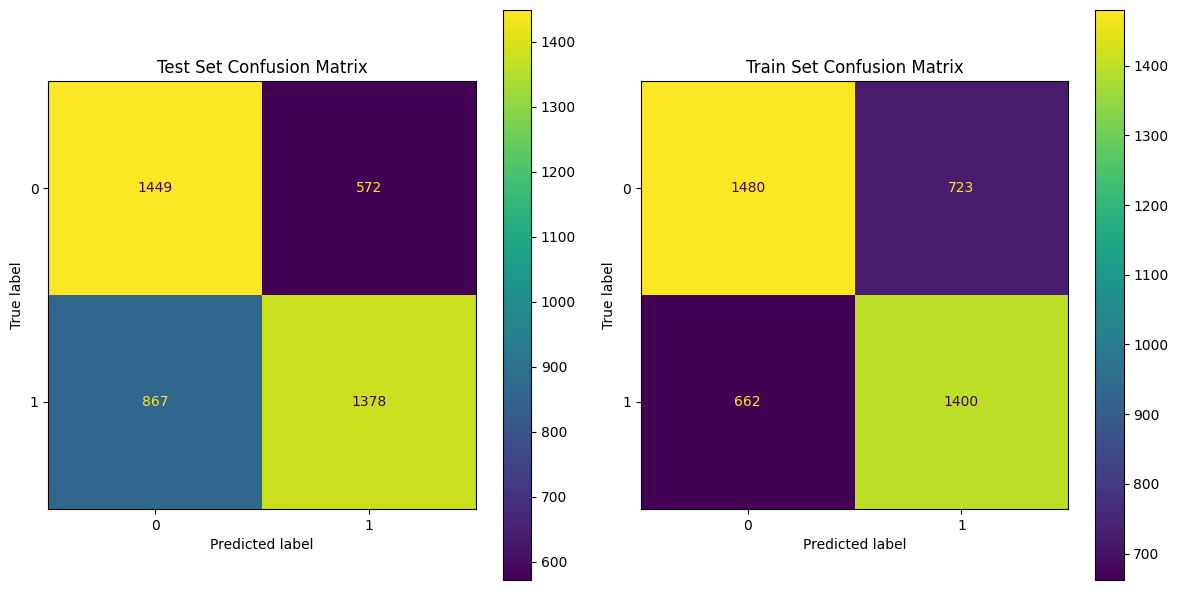

In [64]:
cfm_test = confusion_matrix(y_test, y_preds)
cfm_train = confusion_matrix(y_train, yt_preds)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first confusion matrix (test set) on the first axis
cfm = ConfusionMatrixDisplay(cfm_test)
cfm.plot(ax=axes[0])
axes[0].set_title('Test Set Confusion Matrix')

# Plot the second confusion matrix (train set) on the second axis
cfm_T = ConfusionMatrixDisplay(cfm_train)
cfm_T.plot(ax=axes[1])
axes[1].set_title('Train Set Confusion Matrix')

plt.tight_layout()
plt.show()

In [65]:
cv_score = cross_val_score(model, X, y, scoring='accuracy', cv=5)
print(f"Cross Validation scores: {cv_score}")
print(f"Cross validation mean : {cv_score.mean()}")
print(f"Cross validation std : {cv_score.std()}")

Cross Validation scores: [0.65319274 0.65885111 0.66412661 0.65826495 0.66002345]
Cross validation mean : 0.65889177107435
Cross validation std : 0.003508783634435202


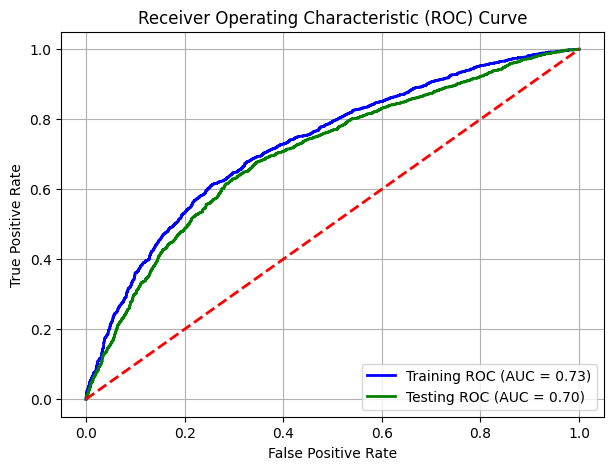

In [66]:
fpr, tpr, thresholds = roc_curve(y_test, y_preds)
roc_auc = roc_auc_score(y_test, y_preds)

# Get predicted probabilities for the positive class
y_train_probs = model.predict_proba(X_train)[:, 1]
y_test_probs = model.predict_proba(X_test)[:, 1]

# Compute ROC curves and AUC scores
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_probs)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_probs)

roc_auc_train = roc_auc_score(y_train, y_train_probs)
roc_auc_test = roc_auc_score(y_test, y_test_probs)

# Plot both ROC curves
plt.figure(figsize=(7, 5))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label=f"Training ROC (AUC = {roc_auc_train:.2f})")
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f"Testing ROC (AUC = {roc_auc_test:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)

# Plot settings
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


## Model testing using a simple python module `backtesting.py`

In [67]:
class ML_Strategy(Strategy):
    def init(self):
        # Load your pre-trained model
        self.model = model
        self.predictions = np.full(data.shape[0], np.nan)

    def next(self):
        # Get the latest input features and make a prediction
        predicted_values = self.model.predict(self.data.df.iloc[-1:, 5:-1])[-1]
        
        if predicted_values==0 and not self.position.is_short:
            self.sell()
        elif predicted_values==1 and not self.position.is_long:
            self.buy()

In [79]:
# get test start date for our backtest to be based on the unseen data
y_test_start_date = y_test.index[0].strftime('%Y-%m-%d %H:%M:%S')

# cash is set to 1,000. But if you will use backtesting.py for BTC, ETH or other cryptocurrencies with high market cap, please increase the cash value as backtesting.py doesn't support it.
bt = Backtest(data[data.index >= y_test_start_date], ML_Strategy, cash=1000, commission=.0016, margin=1/2, trade_on_close=False, exclusive_orders=True)

### Backtesting Metrics (unseen data)
- **Returns**: The model achieve a remarkable `3726.8%`% returns for an initial capital of $`1000`, trading futures with `2x` leverage, from 9/19/23 to 3/14/24.
- **Max Drawdown [%]**: the maximum drawdown was 49%, which, while high, is considered normal for futures trading based on my observation. Any drawdonw below 100% helps avoid liquidation.
- **Winrate**: A 59% winrate aligns well with the model's train/test accuracy metrics
- **Profit Factor**: A 1.5 profit factor indicates a favorable risk-reward ratio

### Conclusion:
The model demonstrates strong performance with high returns that align with the train/test metrics. However, this model can still be improved by:
- adding more features to increase predictive accuracy.
- Incorporating **stop loss** and **take profit** strategies to improve risk management and potentially achieve even higher returns.

In [69]:
stats = bt.run()
stats

Start                     2023-09-19 01:00:00
End                       2024-03-14 18:00:00
Duration                    177 days 17:00:00
Exposure Time [%]                   99.953118
Equity Final [$]                 38268.420554
Equity Peak [$]                  52155.146737
Return [%]                        3726.842055
Buy & Hold Return [%]              138.511639
Return (Ann.) [%]               207224.350429
Volatility (Ann.) [%]           917673.285113
Sharpe Ratio                         0.225815
Sortino Ratio                      2387.82988
Calmar Ratio                      4201.569696
Max. Drawdown [%]                  -49.320698
Avg. Drawdown [%]                   -5.511343
Max. Drawdown Duration       22 days 04:00:00
Avg. Drawdown Duration        1 days 04:00:00
# Trades                                  636
Win Rate [%]                        59.433962
Best Trade [%]                      13.595897
Worst Trade [%]                    -15.130156
Avg. Trade [%]                    

In [70]:
bt.plot();

Total trades winrate: 62.92 %


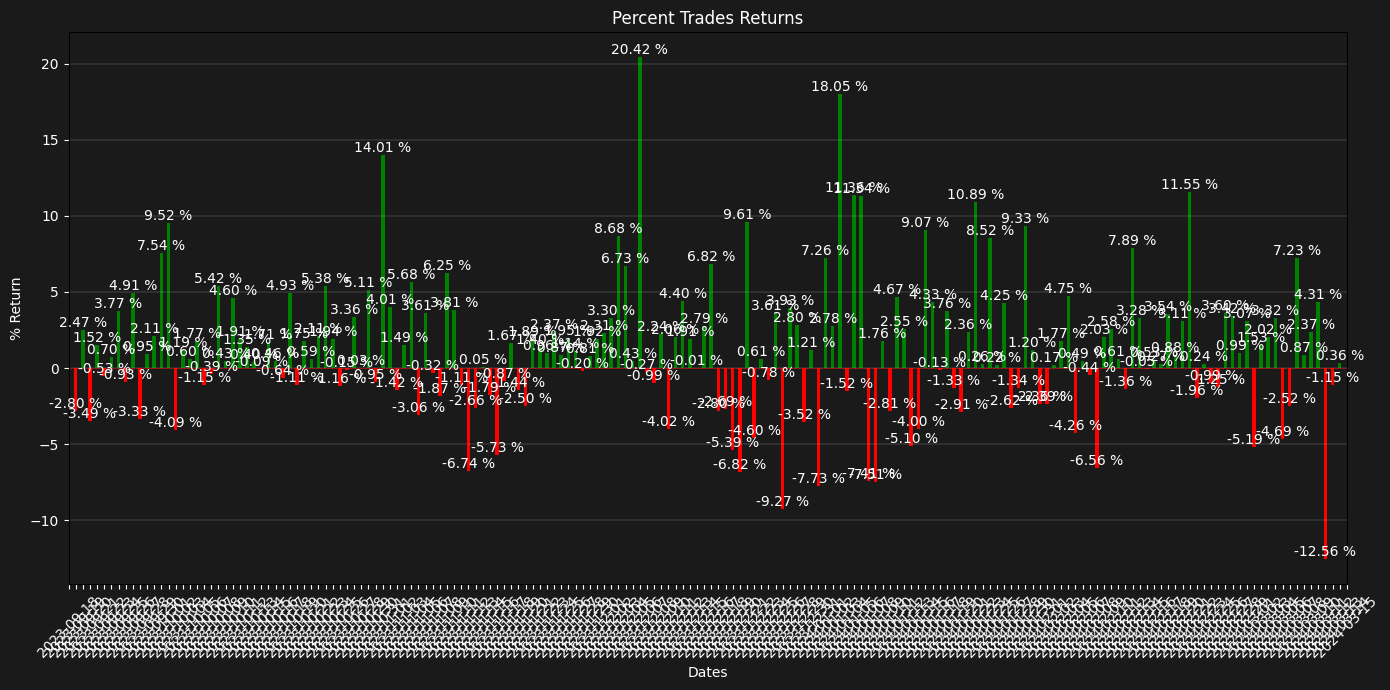

In [71]:
trades = stats._trades.groupby(stats._trades['EntryTime'].dt.date)['ReturnPct'].sum() * 100

winrate = trades[trades.values > 0].shape[0] / trades.shape[0]
print(f"Total trades winrate: {winrate*100:.2f} %")

fig, ax = plt.subplots(figsize=(14, 7))
bar = ax.bar(trades.index, trades.values, width=0.5, color=['green' if x >= 0 else 'red' for x in trades.values])
ax.axhline(color='red', linestyle='--', linewidth=0.5)
ax.set_xlim(trades.index.min() - pd.Timedelta(days=1), trades.index.max() + pd.Timedelta(days=1))
plt.title('Percent Trades Returns', color='white')
plt.ylabel('% Return', color='white')
plt.xlabel('Dates', color='white')
ax.grid(axis='y', linewidth='0.2')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

fig.patch.set_facecolor('#1a1a1a')
ax.set_facecolor('#1a1a1a')
ax.tick_params(colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

plt.xticks(rotation=45)
for i, bar in enumerate(bar):
    plt.text(bar.get_x() + bar.get_width()/2, 
             bar.get_height(), 
             f'{trades.values[i]:.2f} %',
             color='white',
             ha='center', 
             va='bottom')
plt.tight_layout()
plt.show()

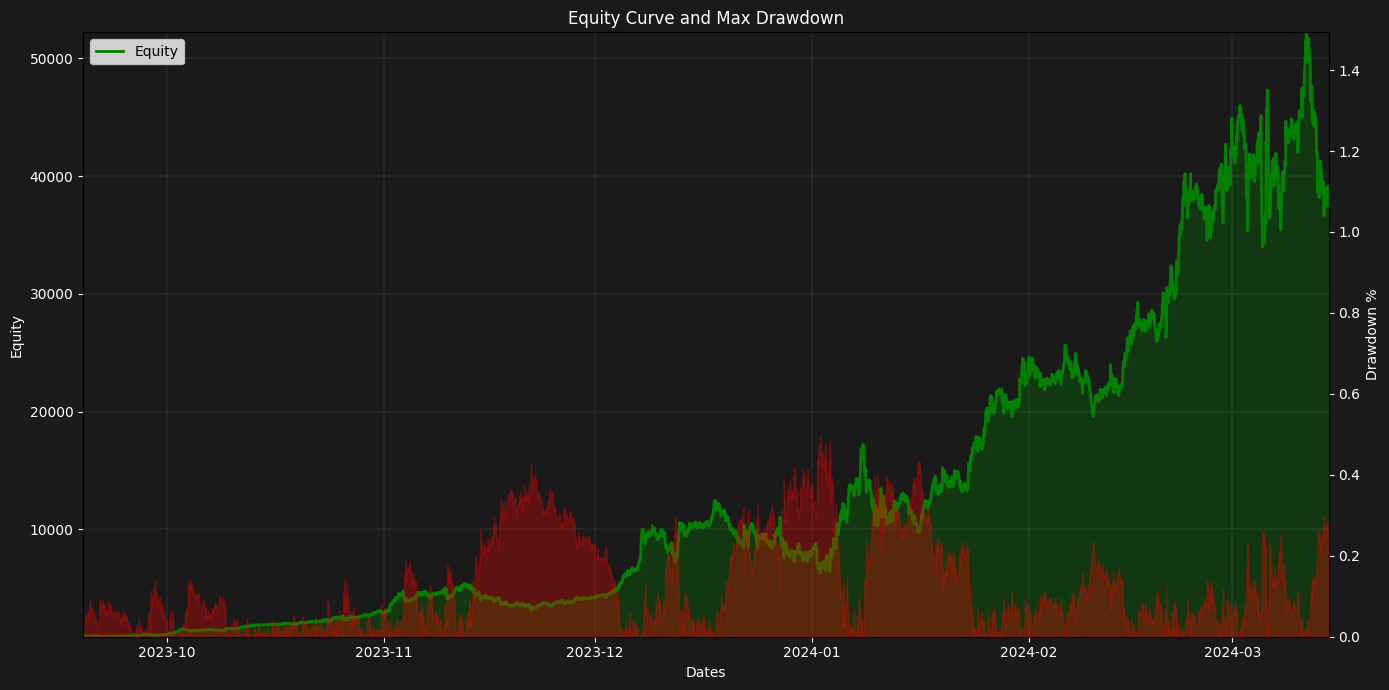

In [72]:
equity_data = stats._equity_curve

fig, ax = plt.subplots(figsize=(14, 7))

# Plotting on the first subplot
ax.plot(equity_data.index, equity_data.Equity, label='Equity', color='green', linewidth=2)
ax.fill_between(equity_data.index, equity_data.Equity, color='green', alpha=0.3)
ax.set_xlim(equity_data.index.min(), equity_data.index.max())
ax.set_ylim(equity_data['Equity'].min() - 15, equity_data['Equity'].max() + 50)
ax.set_title('Equity Curve and Max Drawdown', color='white')
ax.set_xlabel('Dates', color='white')
ax.set_ylabel('Equity', color='white')

ax2 = ax.twinx()
ax2.plot(equity_data.index, equity_data.DrawdownPct, label='DrawdownPct', color='red', linewidth=0)
ax2.fill_between(equity_data.index, equity_data.DrawdownPct, color='red', alpha=0.3)
ax2.set_ylim(equity_data['DrawdownPct'].min(), equity_data['DrawdownPct'].max() + 1)
ax2.set_ylabel('Drawdown %')

fig.patch.set_facecolor('#1a1a1a')
ax.set_facecolor('#1a1a1a')
ax.tick_params(colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

ax2.tick_params(colors='white')
ax2.xaxis.label.set_color('white')
ax2.yaxis.label.set_color('white')

ax.legend()
ax.grid(True, linewidth='0.1')
fig.tight_layout()
plt.show()

In [73]:
print(f"Equity Final : ${stats['Equity Final [$]']:,.2f}")

Equity Final : $38,268.42


In [74]:
long_positions = stats._trades[stats._trades.Size > 0]
short_positions = stats._trades[stats._trades.Size < 0]

long_winrate = long_positions[long_positions.ReturnPct > 0].shape[0] / long_positions.shape[0] * 100
short_winrate = short_positions[short_positions.ReturnPct > 0].shape[0] / short_positions.shape[0] * 100
print(f"LONG positions - winrate: {long_winrate:.2f} %, number of trades: {long_positions.shape[0]}")
print(f"SHORT positions - winrate: {short_winrate:.2f} %, number of trades: {short_positions.shape[0]}")

LONG positions - winrate: 60.69 %, number of trades: 318
SHORT positions - winrate: 58.18 %, number of trades: 318


Average trades per day: 3.57


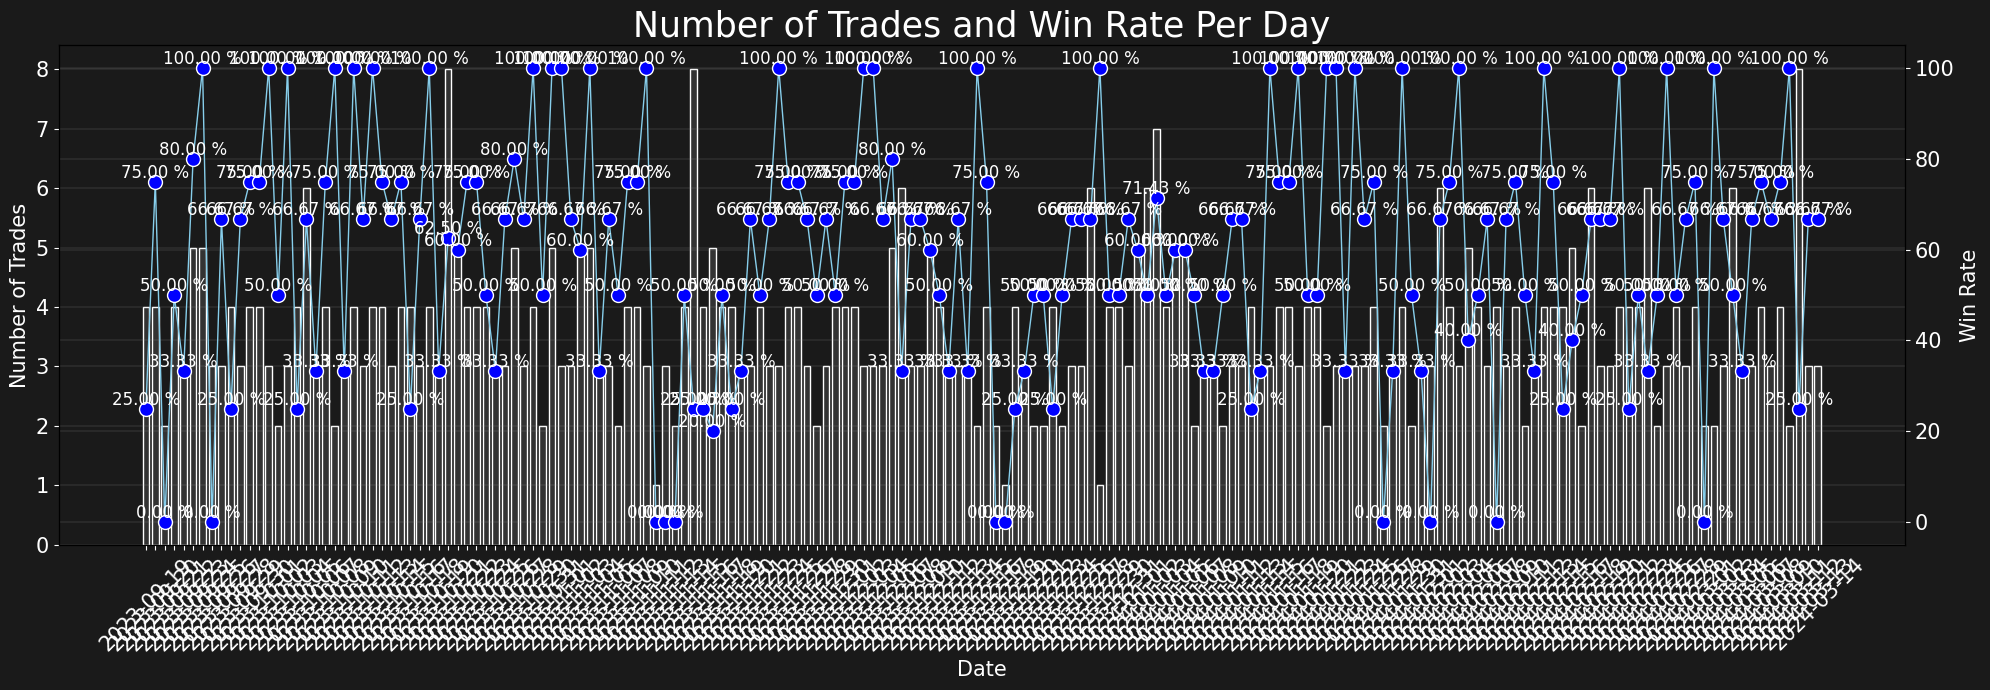

In [75]:
trades_per_day = stats._trades.groupby(stats._trades["EntryTime"].dt.date).size()

print(f'Average trades per day: {trades_per_day.mean():.2f}')

stats._trades['Win'] = stats._trades['PnL'] > 0
win_rate_per_day = stats._trades.groupby(stats._trades['EntryTime'].dt.date)['Win'].mean() * 100

fig, ax1 = plt.subplots(figsize=(20, 7))

ax1.bar(trades_per_day.index, trades_per_day.values, color='#333333', edgecolor='white', width=0.7)
ax1.set_xlabel('Date', fontsize=15)
ax1.set_ylabel('Number of Trades', fontsize=15, color='white')
ax1.tick_params(axis='y', labelcolor='blue', labelsize=15)
ax1.set_title('Number of Trades and Win Rate Per Day', fontsize=25, color='white')
ax1.set_xticks(trades_per_day.index)
ax1.set_xticklabels(trades_per_day.index, rotation=45, fontsize=15)

ax2 = ax1.twinx()
ax2.plot(win_rate_per_day.index, win_rate_per_day.values, color='skyblue', marker='o', mec='white', mfc='blue', markersize=10, linewidth=1)
ax2.set_ylabel('Win Rate', fontsize=15, color='red')
ax2.tick_params(axis='y', labelcolor='red', labelsize=15)

fig.patch.set_facecolor('#1a1a1a')
ax1.set_facecolor('#1a1a1a')
ax1.tick_params(colors='white')
ax1.xaxis.label.set_color('white')
ax1.yaxis.label.set_color('white')
ax2.tick_params(colors='white')
ax2.xaxis.label.set_color('white')
ax2.yaxis.label.set_color('white')

for i, value in enumerate(win_rate_per_day.values):
    ax2.text(win_rate_per_day.index[i], value, f'{value:.2f} %', color='white', ha='center', va='bottom', fontsize=12)

ax1.grid(True, axis='y', alpha=0.6, linewidth='0.25')
ax2.grid(True, axis='y', alpha=0.6, linewidth='0.25')

plt.tight_layout()
plt.show()